In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare training and test set

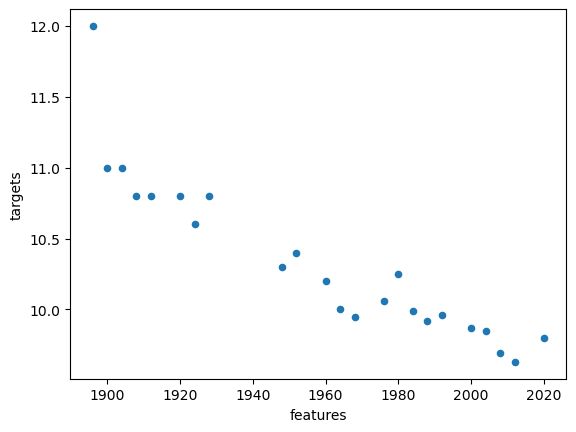

In [4]:
olympics=0
if olympics==0:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    #create using scikit learn a 2 numerical features dataset with 100 samples from a linear distribution
    from sklearn import make_regression
    X,Y=make_regression(n_samples=100, n_features=2, noise=2)
    dataset=pd.DataFrame({'features':X[:,0],'features2':X[:,1],'targets':Y})
from sklearn.model_selection import train_test_split
dataset_train,dataset_test=train_test_split(dataset,test_size=0.2, random_state=42)
X=dataset_train.drop('targets',axis=1).values.reshape(-1,dataset_train.shape[1]-1)
Y=dataset_train['targets'].values.reshape(-1,1)

#plot
if dataset_train.shape[1]==2:
    dataset_train.plot.scatter(x='features',y='targets')

# Perform validation

In [5]:
#coarse to fine approach
from ridge import Ridge_Regression
## given the low amount of data available we decided to do a K-fold cross validation
## the parameter lambda follows a coarse to fine approach
## the coarse search is done with a step of 0.1 and the fine search with a step of 0.01
k=len(X)
fold_size=int(len(X)/k)
lambda_mses=[]
# generate the intervals for the coarse to fine approach from 1 to 10^-20
lambda_values=np.array(10.0 ** np.arange(10, -10, -1))
for lambda_value in lambda_values:
    # print('Lambda value: ',lambda_value)
    ridge=Ridge_Regression(lambda_value)
    mses=[]
    for i in range(k):
        # K-fold cross validation (take the data from the i-th fold as test data)
        Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
        Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
        ridge.Train(Xi,Yi)
        y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
        mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
    lambda_mses.append(np.mean(mses))
    # print('lambda: ',lambda_value,' mse: ',np.mean(mses))
print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
lambda_value=lambda_values[np.argmin(lambda_mses)]

best lambda atm:  100.0


In [10]:
order_of_magnitude=lambda_value
for order in np.array(10.0 ** np.arange(np.log10(order_of_magnitude)+1, -10, -1)):
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1*order,0),lambda_values[np.argmin(lambda_mses)]+1*order,num=(20+1))
    lambda_mses=[]
    for lambda_value in lambda_values:
        # print('lambda_value: ',lambda_value)
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        for i in range(k):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
            Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
            mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        # print('lambda: ',lambda_value,' mse: ',np.mean(lambda_mses))
    # print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    best_mse = np.min(lambda_mses)
    lambda_value=lambda_values[np.argmin(lambda_mses)]

print('best lambda: ',lambda_value)
print('best mse: ',best_mse)

best lambda:  416.67217528076503
best mse:  0.06594373213098846


# Comparison with SciKit Ridge Regression

In [7]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y) ## train on the training dataset
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
y_pred=ridge.Predict(X_test)
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(X_test)
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',Y_test[i])
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',y_pred[i])
    print('scikit: year: ',X_test[i],' time: ',y_pred_sklearn[i])
    
print('w_mio: ',ridge.__str__())
print('w_sklearn: ',ridge_sklearn.coef_,ridge_sklearn.intercept_)
# mse on the training set
print('mse: ',((Y_test-ridge.Predict(X_test))**2).mean())
print('mse sklearn: ',((Y_test-ridge_sklearn.predict(X_test))**2).mean())

year:  [2016]  time:  [9.81]
year:  [1972]  time:  [10.14]
year:  [1956]  time:  [10.5]
year:  [1996]  time:  [9.84]
year:  [1932]  time:  [10.32]
year:  [1936]  time:  [10.3]
year:  [2016]  time:  [9.59932804]
scikit: year:  [2016]  time:  [9.59932804]
year:  [1972]  time:  [10.16217654]
scikit: year:  [1972]  time:  [10.16217654]
year:  [1956]  time:  [10.36684873]
scikit: year:  [1956]  time:  [10.36684873]
year:  [1996]  time:  [9.85516827]
scikit: year:  [1996]  time:  [9.85516827]
year:  [1932]  time:  [10.673857]
scikit: year:  [1932]  time:  [10.673857]
year:  [1936]  time:  [10.62268895]
scikit: year:  [1936]  time:  [10.62268895]
w_mio:  ('Ridge Regression model with weights: ', array([[ 3.53880230e+01],
       [-1.27920114e-02]]))
w_sklearn:  [[-0.01279201]] [35.38802297]
mse:  0.04869612438894045
mse sklearn:  0.048696124388561635


c:\Users\ertwi\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\ertwi\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\ertwi\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\ertwi\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\ertwi\anaconda3\envs\malis\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not w

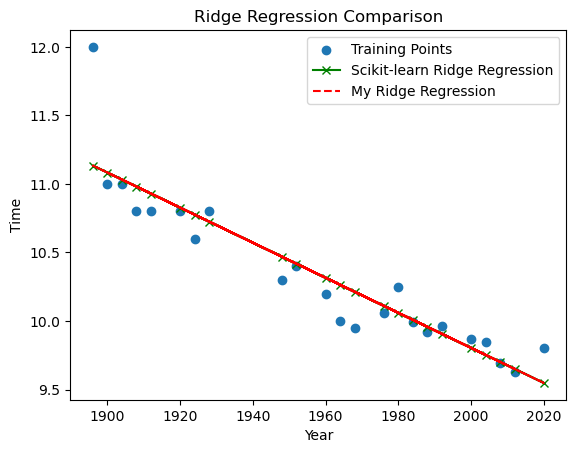

In [8]:
#plot if 1D
if dataset_train.shape[1]==2:
    import matplotlib.pyplot as plt   
    ridge=Ridge_Regression(lambda_value)
    ridge.Train(X,Y)
    y_pred=ridge.Predict(X)
    from sklearn.linear_model import Ridge
    ridge_sklearn=Ridge(alpha=lambda_value)
    ridge_sklearn.fit(X,Y)
    y_pred_sklearn=ridge_sklearn.predict(X)
    from sklearn.linear_model import RidgeCV
    ridge_cv=RidgeCV(cv=k)
    ridge_cv.fit(X,Y)
    y_pred_cv=ridge_cv.predict(X)
    plt.scatter(X, Y, label='Training Points')
    plt.plot(X, y_pred_sklearn, label='Scikit-learn Ridge Regression', color='green', marker="x")
    plt.plot(X, y_pred, label='My Ridge Regression', linestyle='--', color='red')
    
    plt.title('Ridge Regression Comparison')
    plt.xlabel('Year')
    plt.ylabel('Time')
    plt.legend()
    plt.show()